# Pytorch 개발 Process

1. **데이터 준비**
    - Dataset 준비
    - Dataloader 생성

2. **입력과 출력을 연결하는 Layer(층)으로 이뤄진 네트워크(모델)을 정의**
    - **Sequential 방식**: 순서대로 쌓아올린 네트워크로 이뤄진 모델을 생성하는 방식
        - layer를 순서대로 쌓은 모델을 구현할때 간단히 모델을 정의할 수 있다.
        - layer block을 정의하는데 사용할 수 있다.
    - **Subclass 방식**: 네트워크를 정의하는 클래스를 구현.
        - 다양한 구조의 모델을 정의할 수 있다.
        - inializer에서 필요한 layer들을 생성한다.
        - forward(self, X) 메소드에 forward propagation 계산을 구현한다.
    

3. **train**
    - train 함수, test 함수 정의

4. test set 최종평가

# MNIST 이미지 분류 
- **[MNIST](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4) (Modified National Institute of Standards and Technology) database**
- 흑백 손글씨 숫자 0-9까지 10개의 범주로 구분해놓은 데이터셋
- 하나의 이미지는 28 * 28 pixel 의 크기
- 6만개의 Train 이미지와 1만개의 Test 이미지로 구성됨.

In [3]:
#이거 딥러닝할 때 겁나 많이 하는 것들이다. 
#이미 나는 교재에서 많이 했었지?
#근데 순차적으로 잘 정리가 되어 있으므로 복습을 하기에도 용이하다.

#근데 다시 해도 어럽다. 파이토치로 이뤄져서 그런가? 복습을 다시 하자. 주말에 2번 하는 것도 괜찮다.

## import

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


import matplotlib.pyplot as plt
import numpy as np
import os #os에 대해 import을 해야 한다.
#이거는 덤이다.
print("파이토치 버전:",torch.__version__)

#영상 관련된 것은 torchvision에 있다.

#torch는 공통이고, torchvision은 영상처리에 관한 것이다.

파이토치 버전: 2.1.0+cu118


In [5]:
#pip install torch torchvision
#torchvision을 설치하는 구문이다.


### device 설정

In [6]:
#처리를 cpu를 이용을 할지 gqu를 이용을 할지 설정한다.

device = "cuda" if torch.cuda.is_available() else "cpu" #cuda가 true인지 물어보는 구문. 아니라면 cpu이 값이 된다.
print("device:",device)



device: cpu


### 변수 설정

In [8]:
#뒤에서 여러번 사용할 값들을 저장할 변수 +
#모델에 설정할 값(모델 자체,학습할 때 필요한 값 등등)으로 성능에 영향을 주는 값들을 저장할 변수 == 하이퍼 파라미터(hyper parameter)


#BATCH_SIZE는 상수 개념으로 정의를 하는 것이다.
#모델의 파라미터를 업데이트 할 때 사용할 데이터의 개수. 한번에 몇개 데이터를 입력할지를 정의한다. 데이터가 6만개 정도 있는데,
#그걸 한번에 넣을 수는 없잖아..... 그래서 batch_size를 통해 전체 데이터를 1번 다 학습하는 것을 1epoch라고 한다. 
BATCH_SIZE = 256


N_EPOCH = 20  #전체 train dataset을 한번 학습한 것을 1 epoch라고 한다. 
LR = 0.001 #학습률. 파라미터 update을 할 때 gradient 값에 곱해줄 값이다.
#(gradient를 새로운 파라미터 계산할 때 얼마나 반영할지에 대한 비율이다.)


##
# step: 파라미터를 1번 업데이트 하는 단위이다. 1step은 1batch_size이다. 
#epoch: 전체 학습데이터셋을 모두 한번 학습한 것을 1epoch라고 한다. 

print(np.ceil(60000/256)) #총 총 데이터와 batch_size를 구한다.




DATASET_SAVE_PATH = "datasets" #데이터셋을 저장할 디렉토리 경로이다.
MODEL_SAVE_PATH ="models" #학습-평가가 끝나 모델을 저장할 디렉토리 경로이다. 

#디렉토리를 2개를 만든다. 하나는 저장용이고, 하는 model용이다.
os.makedirs(DATASET_SAVE_PATH,exist_ok=True)
os.makedirs(MODEL_SAVE_PATH,exist_ok=True)


235.0


## MNIST dataset Loading

### Dataset

In [9]:
##MNIST 데이터셋을 다운로드 + DATASET 객체를 생성.

#train dataset
#torchvision.datasets


train_set = datasets.MNIST(root=DATASET_SAVE_PATH,
                          train=True, #trainset:훈련용이다.
                          download=True, #root에 저장된 데이터파일들이 없을 때 다운로드를 받을지 여부에 대해.
                           transform = transforms.ToTensor() #데이터 전처리. (전처리:변환하지 않고 쓰겠다.)
                           
                           
                          ) #데이터셋을 저장할 디렉토리 경로.



#ToTensor() : ndarray, PIL.Image 객체 -> torch.Tensor로 변환한다. Pixcel값을 정규화한다.(normalization)
#Pixcel 값 정규화: 0부터 1사이의 실수로 변환한다. 



#testset을 설정해준다. 
test_set = datasets.MNIST(root=DATASET_SAVE_PATH,
                          train=False,
                         download=True,
                         transform=transforms.ToTensor()) #trainset이 False라고 설정하면 된다.



#실행을 하면,  dataset이라는 파일이 하나 생기는 것을 볼 수 있다.

In [10]:
print(type(train_set)) #Dataset 타입.
print(train_set)
print(test_set)

#여러가지 데이터들에 대한 정보를 print을 통해 알아내자!! 



<class 'torchvision.datasets.mnist.MNIST'>
Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: datasets
    Split: Test
    StandardTransform
Transform: ToTensor()


In [11]:
#데이터 포인트 개수

print(len(train_set),len(test_set))


60000 10000


### DataLoader

In [12]:
#Dataset을 모델에 어떻게 제공할지를 설정 => 학습/평가시 설정된 대로 데이터를 loading한다. 
#훈련용 DataLoader


train_loader = DataLoader(train_set,#Dataset
                        batch_size=BATCH_SIZE, #BATCH_SIZE를 설정한다.
                        shuffle = True, #한 epoch이 끝이나면 다음 epoch전에 데이터를 섞을지의 여부.(디폴트:false)
                        drop_last=True,#마지막 batch의 데이터수가 batch_size보다 적을 경우 버릴지(학습에 사용안함) 여부(디폴트:false)
                        

                         )
                          
    
    
#평가용 dataloader

test_loader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=True)


In [13]:
print("1 예폭당 step 수")
print("trainset:", len(train_loader)) #나머지 데이터는 따로 학습을 하지 않은 것이다.
print("testset:",len(test_loader)) #나머지를 학습을....했어?? 띠용




1 예폭당 step 수
trainset: 234
testset: 40


- Dataset: input/output data를 묶어서 관리한다.
- DataLoader:Dataset의 데이터들을 모델에 어떻게 제공할지를 관리한다. 


## 네트워크(모델) 정의
- Network : 전체 모델 구조

In [14]:
#class로 정의 : nn.Moudle을 상속해서 정의한다. 
#nn.Module을 상속받는다. 
#모델을 만들면, 아래의 2가지를 생성할 수 있다. 
class MnistModel(nn.Module):
    def __init__(self):
        """
        모델 객체 생성시 모델을 구현(정의)할 때 필요한 것들을 초기화한다.
        필요한 것: Layer들. 등등.....
        
        """
        
        super().__init__()
        
        
        
        self.lr1 = nn.Linear(28*28,128) #input feature의 크기, output size(임의지정)
        self.lr2  = nn.Linear(128,64)
        self.lr3 = nn.Linear(64,10) #784-----128-----64------10 이런 순으로 간다.
        #이 때, 10은 '각 범주의 확률'이 된다. 
        ### Acrivation함수 --->비선형함수 :ReLU (비선형:직선형이 아니라는 것이다.)
        self.relu = nn.ReLU() #중간중간의 결과값을 변형을 시킬 것이다.  sigmoid 함수 대신에 이걸 쓴다.
        #x값이 뭐냐에 따라서 증감이 달라지는 것이다. 그래서 선형이 아니라 비선형. 
        #input으로 x를 받으면, x와 0을 비교해서 더 큰걸 받는다. 그래서 함수 그래프 그림이 약간 재미있어진다.
        #이 부분에서 정의한 함수들 (4개)를 토대로 forward 함수 부분에서 계산을 할 것이다. 
    
    def forward(self,x):
        
        """
        input data를 입력받아서 output 데이터를 만들 때 까지의 계산 흐름을 정의한다.
        ====> forward propagation
        
        parameter
        x: 입력데이터
        return
            torch.Tensor: 출력데이터(모델 예측결과.)
        
        
        """
        #init 에서 생성한 함수들을 이용해서 계산
        ### x->1차원으로 변환 -> lr1 ->relu ->lr2 ->relu ->lr3 ->output
        pass #나중에 구현
        #input(batch_size,channel,height,width) => (batch_size,전체 pixcel)    
        #전체 pixcel은 channel,height,width을 곱한 것이라고 볼 수 있다.
        x = torch.flatten(x,start_dim=1) #(b,c,h,w)=>(b,c*h*w) #1치원으로 변환 
        x = self.lr1(x) #lr1
        x = self.relu(x)#relu
        
        x = self.lr2(x)
        x = self.relu(x)
        
        output = self.lr3(x)
        return output

In [15]:
### 정의한 모델 클래스로부터 모델 객체를 생성한다.

model = MnistModel()
print(model)

MnistModel(
  (lr1): Linear(in_features=784, out_features=128, bias=True)
  (lr2): Linear(in_features=128, out_features=64, bias=True)
  (lr3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)


In [13]:
###모델의 연산 흐름 및 정보를 확인하자.  ====>torchinfo 패키지를 사용한다. 

#!pip install torchinfo

In [14]:
from torchinfo import summary

summary(model,(100,1,28,28)) #summary(모델객체,input shape:tuple)
#위의 input shape은 784와 같이 변동이 가능하다.

#이렇게 하면, 어떤 순서대로 실행을 시켰는지에 대해 정보가 나온다.
#output shape [100,10]은 100사이즈의 결과가 총 10개 나왔다는 것이다.앞의 100은 batch_size이다. 
#linear, relu들의 output shape를 보면 이 과정에 대해 더 잘 이해할 수 있다.

#그냥 파이토치에서는 이런 상세 정보를 알 수 있는 것이 없다.
#그래서 torchinfo을 통해 이런 정보를 알 수 있다.



Layer (type:depth-idx)                   Output Shape              Param #
MnistModel                               [100, 10]                 --
├─Linear: 1-1                            [100, 128]                100,480
├─ReLU: 1-2                              [100, 128]                --
├─Linear: 1-3                            [100, 64]                 8,256
├─ReLU: 1-4                              [100, 64]                 --
├─Linear: 1-5                            [100, 10]                 650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 10.94
Input size (MB): 0.31
Forward/backward pass size (MB): 0.16
Params size (MB): 0.44
Estimated Total Size (MB): 0.91

In [16]:
### train dataset의 첫번째 배치를 이용해서 모델에 추론하자.
###next와 iter함수가 어떻게 쓰였는지에 대해 복습이 필요하다.
x_batch,y_batch = next(iter(train_loader))     #(input,output) -----각각 학습을 시킨 것과 시키지 않은 것이다.
print(x_batch.shape,y_batch.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


In [17]:
#추론

pred_batch = model(x_batch) #model의 forward() 메소드가 실행.

pred_batch.shape

torch.Size([256, 10])

In [18]:
pred_batch[0].argmax() #첫번째 이미지에 대한 추론 결과!
#첫번째 이미지가 0일 확률,1일확률......9일 확률이다. 이 중에서 가장 확률이 높은 것을 고르면 된다.
#argmax()을 통해 숫자를 볼 수 있지!

tensor(8)

In [19]:
#근데 y_batch[0]을 하면, 당연히 틀리다. 학습을 안시켰으니까!

y_batch[0]

tensor(8)

In [19]:
#원소별로 계산

pred_batch.argmax(dim=1)==y_batch
#뭐 대략 10개중에 1개 정도 맞춘거다. 이건 걍 찍은거다ㅋㅋㅋㅋㅋㅋ

tensor([False, False, False, False, False, False, False,  True, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
        False,  True, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True, False,
        False,  True,  True,  True, False,  True, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
         True, False, False,  True, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, 

In [20]:
i = torch.arange(28*28).reshape(1,1,28,28)
i.shape #[1:데이터개수,1:channel,28:height,28:width]
#1차원 => 데이터개수는 유지 [1,784]
#만약 데이터개수가 5이면 [5,784]를 한다.

##다차원 텐서 => 1차원 =>flatten([start_dim=axis])을 쓴다. #지정한 axis 부터 합친다.

torch.flatten(i,start_dim=1) #axis 0은 유지하고, axis 1부터 나머지를 합친다.


#이건 그냥 예제이다....


tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
         168, 169, 170, 171, 172, 173, 174, 175, 176

## train

### 모델, loss function, optimizer 생성

In [20]:
###모델을 device로 옮긴다.(모델을 이용한 계산을 cpu에서 할지, gpu에서 할지...)
###모델을 이용한 계산을 cpu에서 할지 gpu에서 할지....
###참고로 device로 옮긴다는 것은 model, 주입할 input data, output data 등을 모색한다는 것이다.

model = model.to(device)



###loss function
# 분류문제: cross entropy, 이중분류문제: binary crossentropy   ====> log loss라고 이야기한다. 보통은 log을 쓰거든.
#다중분류:label이 여러개      이진분류: yes/no 분류



loss_fn = nn.CrossEntropyLoss() #nn.functional.cross_entropy() 함수를 써도 된다.
#이 방법은 객체를 생성해서 거시기를 하는 것이다.



#####Optimizer =====>  모델 파라미터들을 최적화


optimizer = torch.optim.Adam(model.parameters(), #최적화 대상 파라미터들
                            lr=LR
                            
                            )
#이번에는 아담이라는 옵티마이저를 쓰자.
##어처피 뭘 쓰든, 경사하강법을 쓰는 것은 동일하다. 그러니 별 상관은 없어.
###







In [21]:
### model.parameters() : generator
a = next(model.parameters())
print(a.shape)
a

torch.Size([128, 784])


Parameter containing:
tensor([[ 0.0280,  0.0249,  0.0018,  ..., -0.0298, -0.0170,  0.0021],
        [ 0.0175,  0.0110,  0.0196,  ...,  0.0019, -0.0293,  0.0263],
        [-0.0313, -0.0249,  0.0098,  ..., -0.0216, -0.0161,  0.0245],
        ...,
        [-0.0190, -0.0195, -0.0312,  ..., -0.0185, -0.0318,  0.0007],
        [-0.0289,  0.0342, -0.0083,  ...,  0.0281, -0.0264, -0.0153],
        [ 0.0249, -0.0169, -0.0304,  ..., -0.0206,  0.0059, -0.0022]],
       requires_grad=True)

### 학습 및 검증

In [23]:




#학습 => train(훈련) + validation(1 epoch 학습한 모델성능을 검증.)
## 에폭별 학습 결과를 저장할 리스트들


train_loss_list =[] #train set으로 검증 시의 loss
val_loss_list =[] #test set으로 검증 시의 loss
val_accuracy_list =[] #test set으로 검증 시의 accuracy(정확도)




#Train 
for epoch in range(N_EPOCH):
    #먼저 학습을 한다!
    model.train()#모델을 train 모드로 변경한다.
    train_loss = 0.0 #현재 epoch의 학습 결과 loss를 저장할 변수.
    
    
    #batch 단위로 학습한다.
    for X_train,y_train in train_loader: #batch 단위 (input,output) 튜플로 반환.
        #1.x,y를 device로 옮긴다. (model,X,y는 같은 device 상에 위치해야 한다.)
        #같은 device 상에 위치하지 않으면 오류가 난다.
        X_train,y_train = X_train.to(device),y_train.to(device)
        #추론
        pred = model(X_train)
        
        #3.loss 계산
        
        loss = loss_fn(pred,y_train) #args 순서: (모델예측값, 정답)
        
        
        #4. 모델의 파라미터 업데이트
        ## 1.파라미터의 gradient값들을 초기화
        optimizer.zero_grad()
        #2.gradient 계산 =====> 계산결과는 파라미터. grad 속성에 저장.
        loss.backward()
        #3.파라미터(weight,bias) 업데이트(파라미터 - 학습률*grad)
        optimizer.step()
        
        
        
        ###현재 batch의 loss 값을 train_loss 변수에 누적한다.
        
        train_loss += loss.item() #Tensor -> 파이썬 값
    #1epoch 학습 종료
    #epoch의 평균 loss를 계산해서 리스트에 저장.(train_loss:step별로 loss를 누적했으므로 평균을 반드시 내 줘야 한다.)
    train_loss_list.append(train_loss/len(train_loader))   #step수로 나눈다.
    
    
    
    #################################################
    # validate(검증) -test set(학습할 때 사용하지 않았던 테스트셋을 이용)
    #################################################
    
    
    model.eval() #모델을 검증(평가) 모드로 변환.
    ## 현재 epoch에 대한 검증경과를 저장할 변수
    val_loss =0.0
    val_acc = 0.0
    
    
    #모델 추정을 위한 연산 -forward propagation
    ## 검증/평가/서비스 ->gradient 계산이 필요없다. =>  도함수를 계산할 필요가 없다.
    
    with torch.no_grad():
        ## batch 단위로 검증
        for X_val, y_val in test_loader:
            #1.device로 옮기기
            X_val,y_val =X_val.to(device),y_val.to(device)
            #2.모델을 이용해 추론
            pred_val = model(X_val)
            #3.검증
            ##1.loss 계산 + val_loss에 누적
            val_loss = val_loss + loss_fn(pred_val,y_val).item() #item 함수는 값만 빼오는 것이다.
            ##2.정확도(accuarcy):맞은것개수/전체개수
            val_acc = val_acc + torch.sum(pred_val.argmax(axis=-1)==y_val).item()
            #식을 자세히 보면 충분히 이해가 가는 부분이니, 복습 시간에 이를 잘 파악하도록 하자.
    #test set 전체에 대한 검증이 완료 => 현 epoch에 대한 검증 완료
    ##  val_loss, val_acc 값을 리스트에 저장한다.
    val_loss_list.append(val_loss / len(test_loader)) #loss는 step 수로 나눈다.
    val_accuracy_list.append(val_acc/len(test_loader.dataset)) #정확도를 append한다.
    
    
    #현재 epoch train 결과를 출력
    print(f"[{epoch+1:2d}/{N_EPOCH:2d}] Train Loss: {train_loss},Val Loss:{train_loss_list[-1]},Val loss:{val_loss_list[-1]}, Val Accuracy: {val_accuracy_list[-1]}")





#보면 점점 loss가 줄어들고, accuracy가 증가했음을 알 수 있다.
#보통은 accuracy가 아닌 loss를 기준으로 성능을 판단한다.

[ 1/20] Train Loss: 127.25238919258118,Val Loss:0.5438136290281247,Val loss:0.2544334940612316, Val Accuracy: 0.9286
[ 2/20] Train Loss: 51.21423093229532,Val Loss:0.2188642347533988,Val loss:0.18922494240105153, Val Accuracy: 0.9444
[ 3/20] Train Loss: 37.68041828274727,Val Loss:0.16102742855874902,Val loss:0.13634217181243002, Val Accuracy: 0.9573
[ 4/20] Train Loss: 29.40886839106679,Val Loss:0.12567892474814868,Val loss:0.11831049602478742, Val Accuracy: 0.9619
[ 5/20] Train Loss: 23.719699501991272,Val Loss:0.1013662371879969,Val loss:0.10411972063593566, Val Accuracy: 0.9678
[ 6/20] Train Loss: 19.540600538253784,Val Loss:0.08350683990706745,Val loss:0.10139821460470558, Val Accuracy: 0.9696
[ 7/20] Train Loss: 16.604674896225333,Val Loss:0.07096014912916809,Val loss:0.09088453110307455, Val Accuracy: 0.9708
[ 8/20] Train Loss: 14.458281129598618,Val Loss:0.06178752619486589,Val loss:0.08592809736146592, Val Accuracy: 0.9722
[ 9/20] Train Loss: 12.190198944881558,Val Loss:0.05209

### 학습 로그 시각화

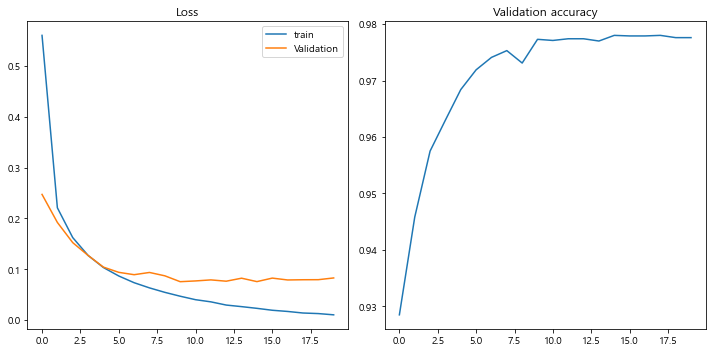

In [37]:
#epoch 별 loss,accuracy의 변화흐름을 시각화
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(N_EPOCH),train_loss_list,label="train")
plt.plot(range(N_EPOCH),val_loss_list,label="Validation")
plt.title("Loss")
plt.legend() #이것을 통해 train과 validation을 잘 파악한다.

plt.subplot(1,2,2)
plt.plot(range(N_EPOCH),val_accuracy_list)
plt.title("Validation accuracy")


plt.tight_layout()
plt.show()


#근데 보면 학습을 너무 많이 시키면 loss가 미세하게 늘어나는 것을 볼 수 있다.

In [24]:
save_path = os.path.join(MODEL_SAVE_PATH,"mnist")
os.makedirs(save_path,exist_ok=True)


save_file_path = os.path.join(save_path,"mnist_mlp.pth") #파일을 만듬.
print(save_file_path)




models\mnist\mnist_mlp.pth


In [25]:
torch.save(model,save_file_path) #파일을 저장. 

## 학습된 모델 저장 및 불러오기

In [26]:
### 모델 불러오기


load_model = torch.load(save_file_path)
load_model

MnistModel(
  (lr1): Linear(in_features=784, out_features=128, bias=True)
  (lr2): Linear(in_features=128, out_features=64, bias=True)
  (lr3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

In [27]:
from torchinfo import summary
summary(load_model,(BATCH_SIZE,1,28,28))

#잘 학습이 된 것인지 확인하기 위해 summary를 통해 정보를 확인한다.




Layer (type:depth-idx)                   Output Shape              Param #
MnistModel                               [256, 10]                 --
├─Linear: 1-1                            [256, 128]                100,480
├─ReLU: 1-2                              [256, 128]                --
├─Linear: 1-3                            [256, 64]                 8,256
├─ReLU: 1-4                              [256, 64]                 --
├─Linear: 1-5                            [256, 10]                 650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 28.00
Input size (MB): 0.80
Forward/backward pass size (MB): 0.41
Params size (MB): 0.44
Estimated Total Size (MB): 1.65

## 모델 평가

In [28]:
#device로 옮기기

load_model = load_model.to(device)

#평가모드 변환
load_model.eval()


test_loss, test_acc = 0.0,0.0


with torch.no_grad():
    for X,y in test_loader:
        #device 옮기기
        X,y = X.to(device),y.to(device)
        #추정
        pred = load_model(X)
        #평가 -loss, accuracy
        test_loss += loss_fn(pred,y)
        test_acc += torch.sum(pred.argmax(axis=-1)==y).item()
    test_loss /= len(test_loader) #step 수로 나누기.
    test_acc /= len(test_loader.dataset) #총 데이터수로 나누기.
print(f"Test loss: {test_loss},Test accuracy: {test_acc}")



#'최종 모델의 성과가 이정도 입니다!'라는 것을 알려주는 코드이다.

Test loss: 0.09755126386880875,Test accuracy: 0.9776


## 새로운 데이터 추론

In [29]:
!pip install opencv-contrib-python


In [30]:
from glob import glob
import cv2

In [31]:
img_file_list = glob("test_img/num/*.png") #png 경로를 가진 것들을 찾는다.

img_file_list

['test_img/num\\eight.png',
 'test_img/num\\eight2.png',
 'test_img/num\\five.png',
 'test_img/num\\four.png',
 'test_img/num\\one.png',
 'test_img/num\\seven.png',
 'test_img/num\\seven2.png',
 'test_img/num\\three.png',
 'test_img/num\\three2.png',
 'test_img/num\\two.png']

In [50]:
file_cnt = len(img_file_list)
print("개수:",file_cnt)


#개수에 따라 zeros로 tensor를 만든다.
input_tensor = torch.zeros((file_cnt,28,28))


for i in range(file_cnt):
    test_img = cv2.imread(img_file_list[i],cv2.IMREAD_GRAYSCALE)
    test_img = cv2.resize(test_img,(28,28))
    #ndarray -> torch.tensor로 변환 + 정규화(0~1) ->input_tensor에 추가한다.
    input_tensor[i]=transforms.ToTensor()(test_img)
    
    

개수: 10


In [54]:
print(type(input_tensor))
print(input_tensor.shape) #28*28짜리가 10개가 있다.
print(input_tensor.min(),input_tensor.max())

<class 'torch.Tensor'>
torch.Size([10, 28, 28])
tensor(0.) tensor(1.)


In [62]:
#추론

load_model.to(device)
load_model.eval()



input_tensor = input_tensor.to(device)

pred_new = load_model(input_tensor)
print(pred_new.shape) #10개 데이터에 대한 확률값이 나오는 것이다.


pred_new #근데 잘 보면.... 확률값이 마이너스가 나올 수 있나? 거참 궁금하네.... 그래서 pred_proba로 바꾼다.
pred_proba = nn.Softmax(dim=-1)(pred_new) #pred_new의 가장 마지막 놈을 softmax로 풀어줘

#모델이 예측한 값을 확률로 변환 =>softmax 함수
print(pred_new.shape,pred_proba.shape) #pred_proba를 통해 모든 값이 다 확률값으로 바뀐다.
pred_new

torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])


tensor([[-4.0875e+00, -8.3930e-01,  2.4044e+00, -1.8152e-01, -1.1501e+01,
         -2.9924e+00,  3.4025e+00, -1.0995e+01,  8.6212e-01, -1.8572e+01],
        [-5.4349e+00, -5.9389e+00, -3.7158e+00,  5.3131e+00, -3.4475e+01,
          6.4566e+00,  4.0780e+00, -2.0936e+01, -2.4654e+00, -1.8884e+01],
        [-1.4542e+01, -8.8649e+00, -6.9787e+00,  3.6781e+00, -6.3461e+00,
          7.7310e+00, -6.0114e+00, -1.0400e+01,  1.9742e+00, -2.4675e+00],
        [-3.8474e+00, -9.2019e+00,  1.7933e+00, -8.8632e+00,  3.2349e+00,
         -7.5968e+00, -6.0340e+00, -9.4439e-01, -7.9913e+00, -3.5238e-01],
        [ 4.0194e-01, -2.9654e-01,  5.6439e-01, -5.2847e+00,  1.2627e+00,
         -3.9683e+00,  1.2894e-02, -2.0012e+00,  4.2700e-02, -8.1756e+00],
        [-7.9451e+00,  1.4018e-01, -4.6891e+00, -3.0984e+00, -3.8588e+00,
         -6.3512e+00, -1.3504e+01,  4.4581e+00, -2.8751e+00,  2.0424e+00],
        [-1.5663e+01, -4.3054e+00, -4.7852e-01,  7.5035e+00, -2.1669e+01,
         -7.1348e+00, -1.2064e+0

In [63]:
pred_proba #확률값으로 바뀐다.

tensor([[3.7446e-04, 9.6405e-03, 2.4706e-01, 1.8611e-02, 2.2590e-07, 1.1195e-03,
         6.7035e-01, 3.7465e-07, 5.2847e-02, 1.9189e-10],
        [4.8514e-06, 2.9309e-06, 2.7069e-05, 2.2578e-01, 1.1854e-18, 7.0844e-01,
         6.5656e-02, 8.9954e-13, 9.4517e-05, 6.9962e-12],
        [2.0812e-10, 6.0762e-08, 4.0070e-07, 1.7021e-02, 7.5424e-07, 9.7984e-01,
         1.0541e-06, 1.3089e-08, 3.0973e-03, 3.6475e-05],
        [6.5586e-04, 3.1003e-06, 1.8473e-01, 4.3500e-06, 7.8094e-01, 1.5434e-05,
         7.3653e-05, 1.1956e-02, 1.0403e-05, 2.1612e-02],
        [1.5335e-01, 7.6265e-02, 1.8039e-01, 5.1999e-04, 3.6265e-01, 1.9395e-03,
         1.0392e-01, 1.3868e-02, 1.0707e-01, 2.8873e-05],
        [3.7181e-06, 1.2070e-02, 9.6467e-05, 4.7337e-04, 2.2129e-04, 1.8303e-05,
         1.4324e-08, 9.0565e-01, 5.9180e-04, 8.0874e-02],
        [8.6843e-11, 7.4324e-06, 3.4128e-04, 9.9925e-01, 2.1389e-13, 4.3888e-07,
         3.1745e-09, 3.9791e-04, 5.3259e-06, 4.8776e-12],
        [2.3276e-03, 2.8010

In [77]:
pred_label_proba = pred_proba.max(dim=-1).values
pred_label_proba#max을 통해 어떤 확률 예측을 했는지 결과가 나온다.

tensor([0.6703, 0.7084, 0.9798, 0.7809, 0.3626, 0.9057, 0.9992, 0.9029, 0.9805,
        0.9463], grad_fn=<MaxBackward0>)

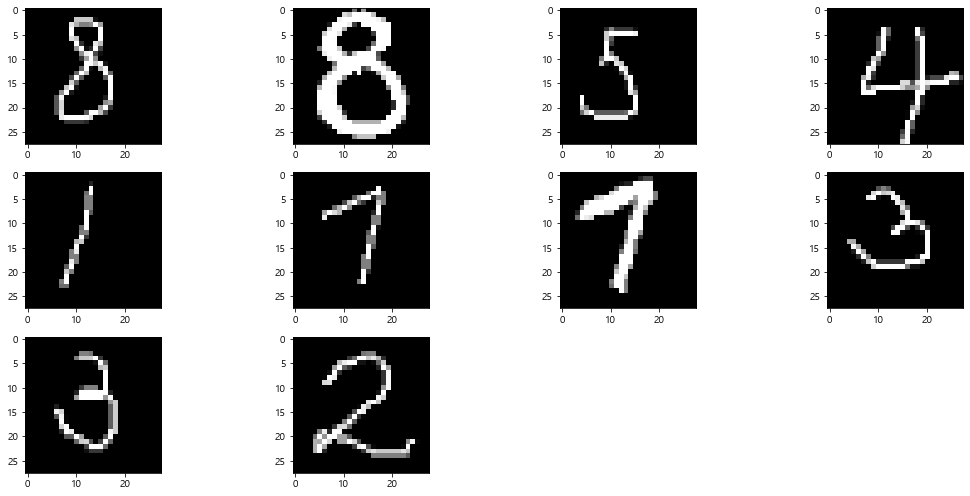

In [85]:
plt.figure(figsize=(15,7))
for i in range(file_cnt):
    plt.subplot(3,4,i+1)
    plt.imshow(input_tensor[i].to("cpu").numpy(),cmap="gray")
    #plt.title(f"{pred_label[i].item()} - {pred_label_proba[i].item():.2f}") #이 부분은 에러났는데, 강사님 코드랑 잘 비교하기.
    

plt.tight_layout() #여백 관련 메소드
plt.show()

In [81]:
#근데 11개 중에서 7개 정도밖에 맞추지 못했다. 이를 해결하기 위해서는 데이터를 더 모아야 한다. 
#그리고 이건 tmi인데, 서양놈들이 데이터를 만들었기 때문에 우리나라의 필기체로 숫자를 구분하려 한다면 오류가 많이 나올 수 있다.
